Replicating fastai caravana challenge notebook for datascience bowl

In [106]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [107]:
import sys 

In [108]:
sys.path.append('../../fastai/')

In [109]:
from utility.utils import *

In [123]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
torch.cuda.set_device(1)

In [111]:
PATH = Path('../data/ds_bowl_2018/')
list(PATH.iterdir())

[PosixPath('../data/ds_bowl_2018/kaggle_fixed'),
 PosixPath('../data/ds_bowl_2018/csv'),
 PosixPath('../data/ds_bowl_2018/submissions'),
 PosixPath('../data/ds_bowl_2018/full_data')]

In [112]:
CSV_DN = 'csv'
TRAIN_DN = 'kaggle_fixed' 

In [113]:
CSV_FILES = list((PATH/CSV_DN).iterdir())

In [114]:
masks_csv = pd.read_csv(CSV_FILES[0])
masks_csv.head()

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3


In [115]:
NUCLEI_ID = '58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd'

In [116]:
list((PATH/TRAIN_DN).iterdir())[:5]

[PosixPath('../data/ds_bowl_2018/kaggle_fixed/e4537e7893e631f3ba6ae5b1023e24b233c78249a31c2f5e561f6c4cad88fcf6'),
 PosixPath('../data/ds_bowl_2018/kaggle_fixed/c00ae67f72816daee468474026e30705003b2d3501f123579a4f0a6366b66aa1'),
 PosixPath('../data/ds_bowl_2018/kaggle_fixed/ef3ef194e5657fda708ecbd3eb6530286ed2ba23c88efb9f1715298975c73548'),
 PosixPath('../data/ds_bowl_2018/kaggle_fixed/d2815f2f616d92be35c7e8dcfe592deec88516aef9ffc9b21257f52b7d6d0354'),
 PosixPath('../data/ds_bowl_2018/kaggle_fixed/7f34dfccd1bc2e2466ee3d6f74ff05821a0e5404e9cf2c9568da26b59f7afda5')]

In [117]:
NUCLEI_IDS = [str(TRAIN_DIR).split('/')[-1] for TRAIN_DIR in list((PATH/TRAIN_DN).iterdir())]

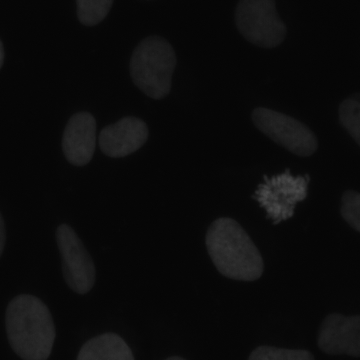

In [118]:
Image.open(PATH/TRAIN_DN/f'{NUCLEI_ID}/images/{NUCLEI_ID}.png')

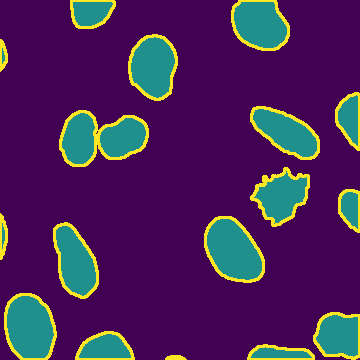

In [119]:
Image.open(PATH/TRAIN_DN/f'{NUCLEI_ID}/mclass_target.png')

In [120]:
ims = [open_image(PATH/TRAIN_DN/f'{NUCLEI_ID}/images/{NUCLEI_ID}.png')
       for NUCLEI_ID in NUCLEI_IDS[:16]]

In [121]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

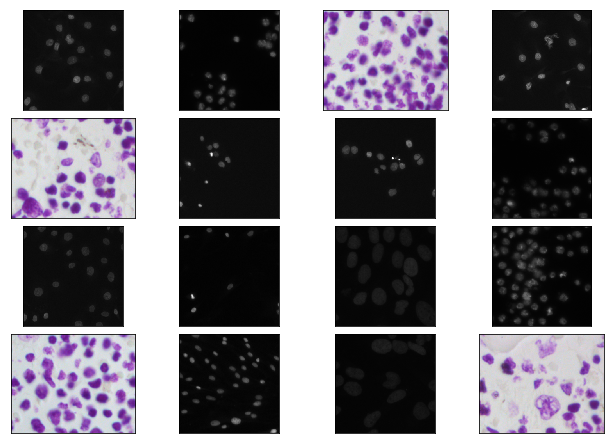

In [122]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

In [19]:
# TOTAL NUMBER OF IMAGES WITH MASK LABELS
n = len(list((PATH/TRAIN_DN).iterdir()))
n

664

### Data Prep

In [124]:
TRAIN_DN = Path('../data/ds_bowl_2018/kaggle_fixed/')

In [125]:
TRAIN_DIRS = list(TRAIN_DN.iterdir())

In [126]:
class FilesDataset(BaseDataset):
    def __init__(self, fnames, transform, path):
        self.path,self.fnames = path,fnames
        super().__init__(transform)
    def get_sz(self): return self.transform.sz
    def get_x(self, i): return open_image(os.path.join(self.path, self.fnames[i]))
    def get_n(self): return len(self.fnames)

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

    def denorm(self,arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
        return self.transform.denorm(np.rollaxis(arr,1,4))

In [127]:
def get_multi_y(y, y_sz = None):
    y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    multi_y = np.dstack([(y == 30)*1,
    (y == 110)*1, 
    (y == 215)*1]).transpose(2,0,1)
    if y_sz is not None:
        multi_y = np.array([cv2.resize(y.astype(np.uint8), (y_sz, y_sz)) for y in multi_y])
    return multi_y.astype(np.float32)

class NucleiDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path, y_sz=256):
        self.y_sz = y_sz
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return get_multi_y(self.y[i], self.y_sz)
    def get_c(self): return 0

In [128]:
TRAIN_X = [str(x_name/'images'/x_name.name) + '.png' for x_name in TRAIN_DIRS]
TRAIN_Y = [str(x_name/'mclass_target.png') for x_name in TRAIN_DIRS]

In [129]:
# create trn, val data
from dataset.validation import *

classes = pd.read_csv('classes.csv')
train_dirs, valid_dirs = get_stratified_valid_dirs(classes, seed=17)

TRN_X = [s for s in TRAIN_X if s.split('/')[-1].split('.')[0] in train_dirs]
VAL_X = [s for s in TRAIN_X if s.split('/')[-1].split('.')[0] not in train_dirs]
TRN_Y = [s for s in TRAIN_Y if s.split('/')[-2] in train_dirs]
VAL_Y = [s for s in TRAIN_Y if s.split('/')[-2] not in train_dirs]

In [130]:
len(TRN_X), len(TRN_Y), len(VAL_X), len(VAL_Y)

(600, 600, 64, 64)

### Model Data

Using Imagenet stats or others

In [131]:
# set model function
PATH = '../data/'
f = resnet18
sz = 256
bs = 8

In [132]:
#stats = [0, 1] # no normalize
#tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=None) # non-imagenet stats
tfms = tfms_from_model(f, sz, crop_type=CropType.NO, tfm_y=None) # imagenet stats
dataset = ImageData.get_ds(NucleiDataset, (TRN_X, TRN_Y), (VAL_X, VAL_Y), tfms=tfms, path=PATH)
md = ImageData(PATH, dataset, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [133]:
x,y = next(iter(md.trn_dl))
x_np, y_np = to_np(x[0]), to_np(y[0])

In [134]:
x_np.min(), x_np.max()

(-1.948059, -0.38518336)

In [135]:
open_image(TRN_X[0]).max()

0.5372549

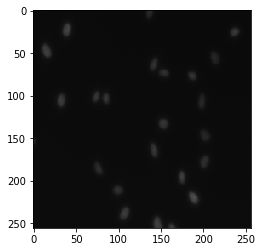

In [136]:
plt.imshow(denorm(x)[0])

### Check Data

In [137]:
x,y = next(iter(md.val_dl))

In [138]:
x_np = to_np(x[0])

In [139]:
y_np = to_np(y[0])

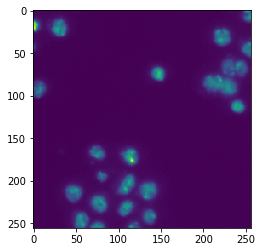

In [140]:
plt.imshow(x_np[1])

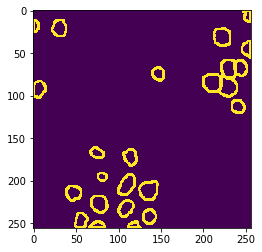

In [141]:
plt.imshow(y_np[2])

### Dyanmic UNET

In [142]:
from torchviz import make_dot

In [143]:
def conv_bn_relu(in_c, out_c, kernel_size, stride, padding):
    return [
        nn.Conv2d(in_c, out_c, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_c)]

In [144]:
# original
class UnetBlock(nn.Module):
    def __init__(self, up_in_c, x_in_c):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(up_in_c, up_in_c//2, 2, 2)
        self.conv1  = nn.Conv2d(x_in_c + up_in_c//2, (x_in_c + up_in_c//2)//2,  3, 1, 1)
        self.conv2  = nn.Conv2d((x_in_c + up_in_c//2)//2, (x_in_c + up_in_c//2)//2,  3, 1, 1)
        self.bn = nn.BatchNorm2d((x_in_c + up_in_c//2)//2)
        
    def forward(self, up_in, x_in):
        up_out = self.upconv(up_in)
        cat_x = torch.cat([up_out, x_in], dim=1)
        x = F.relu(self.conv1(cat_x))
        x = F.relu(self.conv2(x))
        return self.bn(x)

In [145]:
# extract pretrained activations
class SaveFeatures():
    """ Extract pretrained activations"""
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [146]:
def get_sfs_idxs(sfs, last=True):
    """
    Return the saved feature indexes that will be concatenated
    Inputs:
        sfs (list): saved features by hook function, in other words intermediate activations
        last (bool): whether to concatenate only last different activation, or all from the encoder model  
    """
    if last:
        feature_szs = [sfs_feats.features.size()[-1] for sfs_feats in sfs]
        sfs_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
        if feature_szs[0] != feature_szs[1]: sfs_idxs = [0] + sfs_idxs
    else: sfs_idxs = list(range(len(sfs)))
    return sfs_idxs

In [147]:
class DynamicUnet(nn.Module):
    """
    A dynamic implementation of Unet architecture, because calculating connections 
    and channels suck!. When an encoder is passed, this network will 
    automatically construct a decoder after the first single forward pass for any
    given encoder architecture.
    
    Decoder part is heavily based on the original Unet paper:
    https://arxiv.org/abs/1505.04597. 
    
    Inputs:
        encoder(nn.Module): Preferably a pretrained model, such as VGG or ResNet
        last (bool): Whether to concat only last activation just before a size change
        n_classes (int): Number of classes to output in final step of decoder
        
    Important Note: If architecture directly reduces the dimension of an image as soon as the
    first forward pass then output size will not be same as the input size, e.g. ResNet.
    We might add an additional upsample step for these type of situations but this can be
    optional.
    """
    def __init__(self, encoder, last=True, n_classes=3):
        super().__init__()
        self.encoder = encoder
        self.n_children = len(list(encoder.children()))
        self.sfs = [SaveFeatures(encoder[i]) for i in range(self.n_children)]
        self.last = last
        self.n_classes = n_classes
    
    def forward(self, x):
        # encoder output
        x = F.relu(self.encoder(x))
        
        # initialize sfs_idxs, sfs_szs, middle_in_c and middle_conv only once
        if not hasattr(self, 'middle_conv'):
            setattr(self, 'sfs_szs', [sfs_feats.features.size() for sfs_feats in self.sfs])
            setattr(self, 'sfs_idxs', get_sfs_idxs(self.sfs, self.last))
            middle_in_c = self.sfs_szs[-1][1]
            middle_conv = nn.Sequential(*conv_bn_relu(middle_in_c, middle_in_c*2, 3, 1, 1),
                                        *conv_bn_relu(middle_in_c*2, middle_in_c, 3, 1, 1))
            setattr(self, 'middle_conv', middle_conv)
        
        # middle conv
        x = self.middle_conv(x)
        
        # initialize upmodel and 1x1 final conv
        if not hasattr(self, 'upmodel'):
            upmodel = []
            for idx in self.sfs_idxs[::-1]:
                features = self.sfs[idx].features
                up_in_c, x_in_c = int(x.size()[1]), int(self.sfs_szs[idx][1])
                unet_block = UnetBlock(up_in_c, x_in_c)
                upmodel.append(unet_block)
                x = unet_block(x, self.sfs[idx].features)
            setattr(self, 'upmodel', nn.Sequential(*upmodel)) 
            final_conv = nn.Conv2d(x.size()[1], self.n_classes, 1)
            setattr(self, 'final_conv', final_conv) 
        # run upsample 
        else:
            for block, idx in zip(self.upmodel, self.sfs_idxs[::-1]):
                x = block(x, self.sfs[idx].features)
        out = self.final_conv(x)
        return out

In [148]:
class DynamicUnet(nn.Module):
    """
    A dynamic implementation of Unet architecture, because calculating connections 
    and channels suck!. When an encoder is passed, this network will 
    automatically construct a decoder after the first single forward pass for any
    given encoder architecture.
    
    Decoder part is heavily based on the original Unet paper:
    https://arxiv.org/abs/1505.04597. 
    
    Inputs:
        encoder(nn.Module): Preferably a pretrained model, such as VGG or ResNet
        last (bool): Whether to concat only last activation just before a size change
        n_classes (int): Number of classes to output in final step of decoder
        
    Important Note: If architecture directly reduces the dimension of an image as soon as the
    first forward pass then output size will not be same as the input size, e.g. ResNet.
    We might add an additional upsample step for these type of situations but this can be
    optional.
    """
    def __init__(self, encoder, last=True, n_classes=3):
        super().__init__()
        self.encoder = encoder
        self.n_children = len(list(encoder.children()))
        self.sfs = [SaveFeatures(encoder[i]) for i in range(self.n_children)]
        self.last = last
        self.n_classes = n_classes
    
    def forward(self, x):
        # encoder output
        x = F.relu(self.encoder(x))
        
        # initialize sfs_idxs, sfs_szs, middle_in_c and middle_conv only once
        if not hasattr(self, 'middle_conv'):
            self.sfs_szs = [sfs_feats.features.size() for sfs_feats in self.sfs]
            self.sfs_idxs = get_sfs_idxs(self.sfs, self.last)            
            middle_in_c = self.sfs_szs[-1][1]
            middle_conv = nn.Sequential(*conv_bn_relu(middle_in_c, middle_in_c*2, 3, 1, 1),
                                        *conv_bn_relu(middle_in_c*2, middle_in_c, 3, 1, 1))
            self.middle_conv = middle_conv
        
        # middle conv
        x = self.middle_conv(x)
        
        # initialize upmodel and 1x1 final conv
        if not hasattr(self, 'upmodel'):
            upmodel = []
            for idx in self.sfs_idxs[::-1]:
                features = self.sfs[idx].features
                up_in_c, x_in_c = int(x.size()[1]), int(self.sfs_szs[idx][1])
                unet_block = UnetBlock(up_in_c, x_in_c)
                upmodel.append(unet_block)
                x = unet_block(x, self.sfs[idx].features)
            self.upmodel = nn.Sequential(*upmodel)
            
            # fix ResNet like models; add an extra UnetBlock
            #if x.size()[-2:] != self.sfs_szs[0][-2:]:
            if False:
                extra_in_c = self.upmodel[-1].conv2.out_channels
                self.add_module('extra_block', nn.ConvTranspose2d(extra_in_c, extra_in_c, 2, 2))
                
            # final 1x1 conv 
            if hasattr(self, 'extra_block'):
                final_in_c = self.extra_block.out_channels
            else: final_in_c = self.upmodel[-1].conv2.out_channels
                
            self.final_conv = nn.Conv2d(final_in_c, self.n_classes, 1)

        # run upsample 
        for block, idx in zip(self.upmodel, self.sfs_idxs[::-1]):
            x = block(x, self.sfs[idx].features)
    
        if hasattr(self, 'extra_block'):
            x = self.extra_block(x)
        
        out = self.final_conv(x)
        return out

In [150]:
# FINAL VERSION

class DynamicUnet(nn.Module):
    """
    A dynamic implementation of Unet architecture, because calculating connections 
    and channels suck!. When an encoder is passed, this network will 
    automatically construct a decoder after the first single forward pass for any
    given encoder architecture.
    
    Decoder part is heavily based on the original Unet paper:
    https://arxiv.org/abs/1505.04597. 
    
    Inputs:
        encoder(nn.Module): Preferably a pretrained model, such as VGG or ResNet
        last (bool): Whether to concat only last activation just before a size change
        n_classes (int): Number of classes to output in final step of decoder
        
    Important Note: If architecture directly reduces the dimension of an image as soon as the
    first forward pass then output size will not be same as the input size, e.g. ResNet.
    In order to resolve this problem architecture will add an additional extra conv transpose 
    layer.
    """
    def __init__(self, encoder, last=True, n_classes=3):
        super().__init__()
        self.encoder = encoder
        self.n_children = len(list(encoder.children()))
        self.sfs = [SaveFeatures(encoder[i]) for i in range(self.n_children)]
        self.last = last
        self.n_classes = n_classes
    
    def forward(self, x):
        # encoder output
        x = F.relu(self.encoder(x))
        
        # initialize sfs_idxs, sfs_szs, middle_in_c and middle_conv only once
        if not hasattr(self, 'middle_conv'):
            self.sfs_szs = [sfs_feats.features.size() for sfs_feats in self.sfs]
            self.sfs_idxs = get_sfs_idxs(self.sfs, self.last)
            middle_in_c = self.sfs_szs[-1][1]
            middle_conv = nn.Sequential(*conv_bn_relu(middle_in_c, middle_in_c*2, 3, 1, 1),
                                        *conv_bn_relu(middle_in_c*2, middle_in_c, 3, 1, 1))
            self.middle_conv = middle_conv
        
        # middle conv
        x = self.middle_conv(x)
        
        # initialize upmodel and 1x1 final conv
        if not hasattr(self, 'upmodel'):
            x_copy = x
            upmodel = []
            for idx in self.sfs_idxs[::-1]:
                features = self.sfs[idx].features
                up_in_c, x_in_c = int(x_copy.size()[1]), int(self.sfs_szs[idx][1])
                unet_block = UnetBlock(up_in_c, x_in_c)
                upmodel.append(unet_block)
                x_copy = unet_block(x_copy, self.sfs[idx].features)
                self.upmodel = nn.Sequential(*upmodel)
            
            if inp.size()[-2:] != m.sfs_szs[0][-2:]:
                extra_in_c = self.upmodel[-1].conv2.out_channels
                self.extra_block = nn.ConvTranspose2d(extra_in_c, extra_in_c, 2, 2)
            
            # final 1x1 conv 
            final_in_c = self.upmodel[-1].conv2.out_channels
            self.final_conv = nn.Conv2d(final_in_c, self.n_classes, 1)
        
        
        # run upsample
        for block, idx in zip(self.upmodel, self.sfs_idxs[::-1]):
            x = block(x, self.sfs[idx].features)
        if hasattr(self, 'extra_block'):
            x = self.extra_block(x)
            
        out = self.final_conv(x)
        return out

### ENCODER: RESNET18

Has `extra_block` to output the original image size

Steps of creating a Dynamic Unet Model:

- Choose your encoder model or define it yourself (make sure it's downsampling as H, W -> H//2, W//2)
- Initialize DynamicUnet as m = DynamicUnet(encoder)
- In order to get the model to gpu set m = m.cuda()

In [207]:
# load defined model
def get_encoder(f, cut):
    base_model = (cut_model(f(True), cut))
    return nn.Sequential(*base_model)

In [208]:
f = resnet18
cut, cut_lr = model_meta[f]
cut, cut_lr

(8, 6)

In [209]:
encoder = get_encoder(f, cut)

In [210]:
m = DynamicUnet(encoder)

In [211]:
inp = torch.ones(1, 3, 256, 256)
out = m(V(inp))

In [212]:
out.size()

torch.Size([1, 3, 256, 256])

In [213]:
inp.size()

torch.Size([1, 3, 256, 256])

In [214]:
m

DynamicUnet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=

### ENCODER: RESNET50

Has `extra_block` to output the original image size

In [159]:
f = resnet50
cut, cut_lr = model_meta[f]
cut, cut_lr

(8, 6)

In [160]:
encoder = get_encoder(f, cut)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/qipm/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:19<00:00, 5202476.36it/s] 


In [161]:
m = DynamicUnet(encoder)

In [162]:
inp = torch.ones(1, 3, 256, 256)
out = m(V(inp))

In [163]:
out.size()

torch.Size([1, 3, 256, 256])

In [164]:
m

DynamicUnet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e

### ENCODER: VGG16 

Doesn't have `extra_block`

In [165]:
f = vgg16
cut, cut_lr = model_meta[f]
cut, cut_lr

(0, 22)

In [166]:
encoder = get_encoder(f, 30)
m = DynamicUnet(encoder)

In [167]:
inp = torch.ones(1, 3, 256, 256)
out = m(V(inp))

In [168]:
out.size()

torch.Size([1, 3, 256, 256])

In [169]:
m

DynamicUnet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

In [170]:
# Wrap everything nicely
class UpsampleModel():
    def __init__(self, model, cut_lr, name='upsample'):
        self.model,self.name, self.cut_lr = model, name, cut_lr

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.encoder), [self.cut_lr]))
        return lgs + [children(self.model)[1:]]

In [171]:
# put model weights into gpu
#m = m.cuda()

### Training Definitions

In [172]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[...,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[...,0], 0.)

def dice(pred, targs):
    m1 = (pred[:,0]>0).float()
    m2 = targs[...,0]
    return 2. * (m1*m2).sum() / (m1+m2).sum()

def multi_acc(logits, targets):
    bs, c, h, w = logits.size()
    out2 = logits.view(bs,c,h*w).transpose(2,1).contiguous()
    input_ = out2.view(bs*h*w,c)

    # target for cross entropy
    _, idx = torch.max(targets, 1)
    target = idx.view(-1)

    return sum(torch.max(input_, dim=1)[1] == target) / len(target)

In [173]:
# since I am training on multiclass data, loss_fn will be different
class MulticlassBCELoss2d(nn.Module):
    """
    Weights for a single sample which is repeated along the batch
    Inputs:
        weight: weigth tensor for a single sample
    """
    def __init__(self):
        super(MulticlassBCELoss2d, self).__init__()
        
    def forward(self, logits, targets):
        # input for cross entropy
        bs, c, h, w = logits.size()
        out2 = logits.view(bs,c,h*w).transpose(2,1).contiguous()
        input_ = out2.view(bs*h*w,c)
        
        # target for cross entropy
        _, idx = torch.max(targets, 1)
        target = idx.view(-1)
        return F.cross_entropy(input_, target)

### Test Loss and Metric

In [174]:
targ = torch.stack([torch.ones(3,3)*0, torch.ones(3,3)*0, torch.ones(3,3)], dim=0)[None, :]
inp = torch.stack([torch.ones(3,3)*0.3, torch.ones(3,3)*0.3, torch.ones(3,3)*0.4], dim=0)[None, :]

In [175]:
# imagine all ground truth is class 2
# output logits are given
inp, targ

(
 (0 ,0 ,.,.) = 
   0.3000  0.3000  0.3000
   0.3000  0.3000  0.3000
   0.3000  0.3000  0.3000
 
 (0 ,1 ,.,.) = 
   0.3000  0.3000  0.3000
   0.3000  0.3000  0.3000
   0.3000  0.3000  0.3000
 
 (0 ,2 ,.,.) = 
   0.4000  0.4000  0.4000
   0.4000  0.4000  0.4000
   0.4000  0.4000  0.4000
 [torch.FloatTensor of size 1x3x3x3], 
 (0 ,0 ,.,.) = 
   0  0  0
   0  0  0
   0  0  0
 
 (0 ,1 ,.,.) = 
   0  0  0
   0  0  0
   0  0  0
 
 (0 ,2 ,.,.) = 
   1  1  1
   1  1  1
   1  1  1
 [torch.FloatTensor of size 1x3x3x3])

In [176]:
loss = MulticlassBCELoss2d()

In [177]:
loss(V(inp), V(targ))

Variable containing:
 1.0331
[torch.FloatTensor of size 1]

In [178]:
F.softmax(V(inp))

Variable containing:
(0 ,0 ,.,.) = 
  0.3220  0.3220  0.3220
  0.3220  0.3220  0.3220
  0.3220  0.3220  0.3220

(0 ,1 ,.,.) = 
  0.3220  0.3220  0.3220
  0.3220  0.3220  0.3220
  0.3220  0.3220  0.3220

(0 ,2 ,.,.) = 
  0.3559  0.3559  0.3559
  0.3559  0.3559  0.3559
  0.3559  0.3559  0.3559
[torch.FloatTensor of size 1x3x3x3]

In [179]:
# softmax(.., ..., 0.400) = (..., ..., 0.3559)
- np.log(0.3559)

1.03310548646599

In [180]:
multi_acc(inp, targ)

1.0

### Put everything together + Training (ResNet18)

#### 1) Define Encoder

In [230]:
f = resnet18
cut, cut_lr = model_meta[f]
cut, cut_lr

(8, 6)

#### 2) Specify Cut and Init DynamicUnet

Put model to gpu if you like

In [237]:
encoder = get_encoder(f, 8)
m = DynamicUnet(encoder)

# create a dummy input - I couldn't find a work around for this to keep up with cpu - gpu tensor weight
# incostencies so it's best to make a single forward pass ourselves
inp = torch.ones(1,3,256,256)
out = m(V(inp))

#### 3) Put to GPU (Optional) - Check Decoder Network

In [238]:
m = m.cuda(1)

In [239]:
m

DynamicUnet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=

#### 4) Wrap DynamicUnet to be Fast.ai Ready

`cut_lr` will be used to group layers for freezing

In [240]:
# specify layer groups pre-freezing
# cut_lr is experimental and heavily dependent on data you have, let's try 9
models = UpsampleModel(m, cut_lr=6)

#### 5) Create learn object

In [241]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit = MulticlassBCELoss2d()
learn.metrics=[multi_acc]

#### 6) Check your layers to make

In [243]:
learn.models.get_layer_groups(False)[1]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
     (downsample): Sequential(
       (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
   )
 ), Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(2

In [244]:
# freeze first 3 conv bn relu
learn.freeze_to(1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 62/75 [00:05<00:01, 11.53it/s, loss=20]   


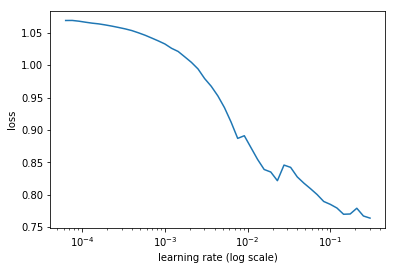

In [245]:
learn.lr_find()
learn.sched.plot()

In [246]:
lr = 0.1
learn.fit(lr,1,cycle_len=4,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   multi_acc                 
    0      0.323598   0.742091   0.852121  
    1      0.25625    0.173255   0.926435                  
    2      0.217069   0.152651   0.937346                  
    3      0.198578   0.146623   0.938645                  



[0.14662303, 0.9386446475982666]

In [87]:
val_preds = learn.predict_dl(md.val_dl)

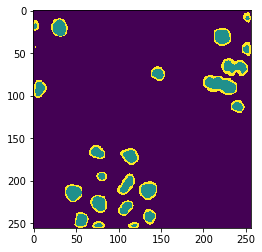

In [92]:
plt.imshow(np.argmax(val_preds[0], 0))